In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import (Dense, Conv2D, Conv2DTranspose, Flatten,
                                     MaxPool2D, GlobalAvgPool2D, LeakyReLU, 
                                     Reshape, Input, Embedding, multiply, 
                                     BatchNormalization, GlobalMaxPool2D)
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop

import numpy as np
from tqdm import tqdm

In [13]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

# Data processing

In [14]:
def normalize_img(image):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255.


(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

X_train = normalize_img(X_train)
X_test = normalize_img(X_test)

# Create models

In [15]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(7*7*128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, 3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, 3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(1, 3, strides=1, padding='same', activation='sigmoid'))
    return model


def create_embedding_g(output_dim):
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(10, output_dim)(label)
    label_embedding = Flatten()(label_embedding)
    return label, label_embedding


def build_generator_embedding(img_shape):
    z = Input(shape=(z_dim,))
    generator = build_generator(img_shape, z_dim)
    # generator.summary()
    label, label_embedding = create_embedding_g(z_dim)
    img = generator(multiply([z, label_embedding]))
    generator = Model([z, label], img)
    return generator

In [16]:
def build_discriminator(img_shape, header=True):
    input = Input(shape=(img_shape))
    model = Conv2D(128, 3, strides=2, padding='same')(input)
    model = LeakyReLU(alpha=0.2)(model)
    model = Conv2D(128, 3, strides=2, padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Conv2D(128, 3, strides=1, padding='same')(model)
    model = GlobalMaxPool2D()(model)
    if header is True:
        model = Dense(1, activation='sigmoid')(model)
    output = model
    model = Model(input, output)
    return input, output, model


def create_embedding_d(output_shape):
    dim = lambda x, y, z: x*y*z
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(10, dim(*output_shape))(label)
    label_embedding = Reshape(output_shape)(label_embedding)
    model = Model(label, label_embedding)
    return label, label_embedding, model


def build_discriminator_embedding(img_shape):
    img_d = Input(shape=(img_shape))
    input_label, output_label, model_label = create_embedding_d(img_shape)
    # model_label.summary()

    input_discriminator, output_discriminator, model_discriminator = build_discriminator(img_shape, True)
    # model_discriminator.summary()

    multiplied = multiply([img_d, output_label])
    final_output = model_discriminator(multiplied)
    model = Model([img_d, input_label], final_output)
    return model

In [17]:
def build_gan(generator, discriminator, z_dim):
    discriminator.trainable = False
    gan_input_dim = Input(shape=(z_dim,))
    gan_input_label = Input(shape=(1,), dtype='int32')
    gan_input = [gan_input_dim, gan_input_label]
    x = generator(gan_input)
    gan_output = discriminator([x, gan_input_label])
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan


def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

# Compile models

In [18]:
generator = build_generator_embedding(img_shape)
# generator.summary()

discriminator = build_discriminator_embedding(img_shape)
# discriminator.summary()

optimizer = Adam(lr=0.0002)  # beta_1=0.5
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

optimizer = Adam(lr=0.0002)  # beta_1=0.5
gan = build_gan(generator, discriminator, z_dim)
gan.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# Train model

100%|██████████| 468/468 [00:27<00:00, 16.82it/s]


epoch = 102/150, d_loss=0.675, g_loss=0.796                                                                                                     


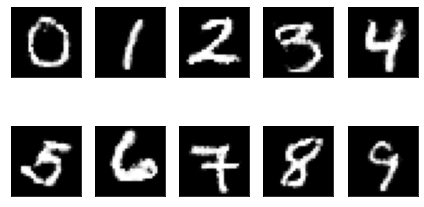

100%|██████████| 468/468 [00:27<00:00, 17.28it/s]


epoch = 103/150, d_loss=0.677, g_loss=0.798                                                                                                     


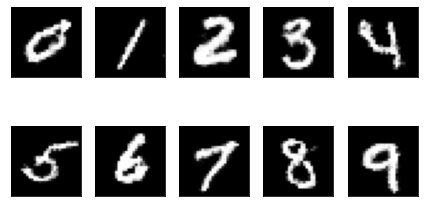

100%|██████████| 468/468 [00:27<00:00, 17.27it/s]


epoch = 104/150, d_loss=0.666, g_loss=0.820                                                                                                     


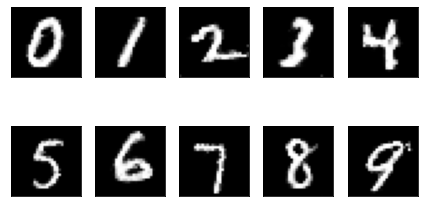

100%|██████████| 468/468 [00:27<00:00, 16.86it/s]


epoch = 105/150, d_loss=0.678, g_loss=0.835                                                                                                     


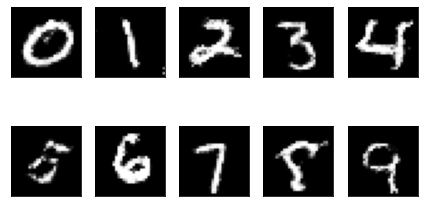

100%|██████████| 468/468 [00:26<00:00, 17.35it/s]


epoch = 106/150, d_loss=0.671, g_loss=0.815                                                                                                     


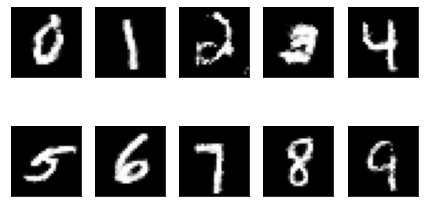

100%|██████████| 468/468 [00:27<00:00, 16.88it/s]


epoch = 107/150, d_loss=0.678, g_loss=0.853                                                                                                     


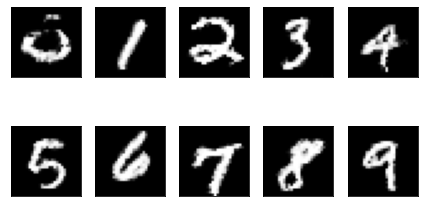

100%|██████████| 468/468 [00:26<00:00, 17.36it/s]


epoch = 108/150, d_loss=0.680, g_loss=0.807                                                                                                     


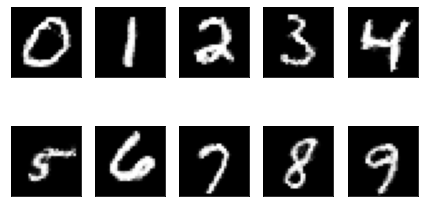

100%|██████████| 468/468 [00:27<00:00, 16.76it/s]


epoch = 109/150, d_loss=0.677, g_loss=0.835                                                                                                     


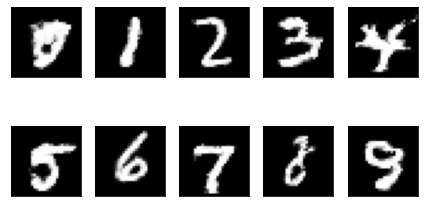

100%|██████████| 468/468 [00:27<00:00, 17.31it/s]


epoch = 110/150, d_loss=0.687, g_loss=0.839                                                                                                     


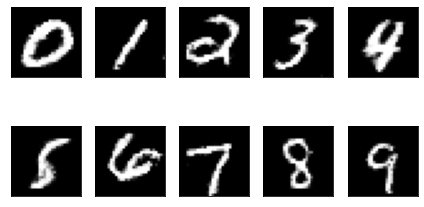

100%|██████████| 468/468 [00:27<00:00, 16.74it/s]


epoch = 111/150, d_loss=0.684, g_loss=0.821                                                                                                     


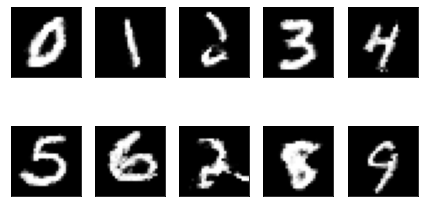

100%|██████████| 468/468 [00:26<00:00, 17.37it/s]


epoch = 112/150, d_loss=0.685, g_loss=0.832                                                                                                     


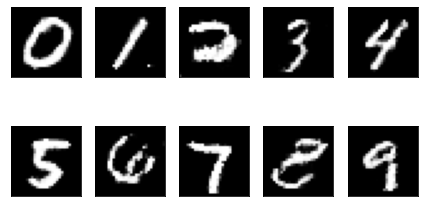

100%|██████████| 468/468 [00:27<00:00, 16.73it/s]


epoch = 113/150, d_loss=0.674, g_loss=0.832                                                                                                     


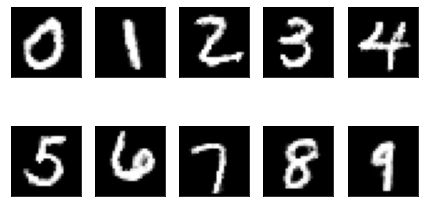

100%|██████████| 468/468 [00:27<00:00, 17.23it/s]


epoch = 114/150, d_loss=0.673, g_loss=0.821                                                                                                     


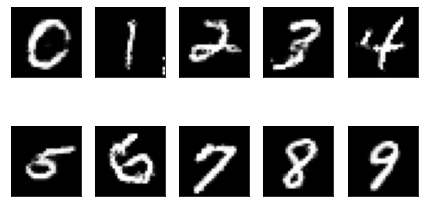

100%|██████████| 468/468 [00:27<00:00, 17.01it/s]


epoch = 115/150, d_loss=0.691, g_loss=0.811                                                                                                     


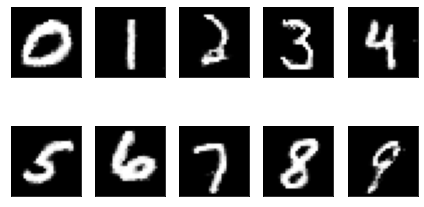

100%|██████████| 468/468 [00:26<00:00, 17.42it/s]


epoch = 116/150, d_loss=0.681, g_loss=0.849                                                                                                     


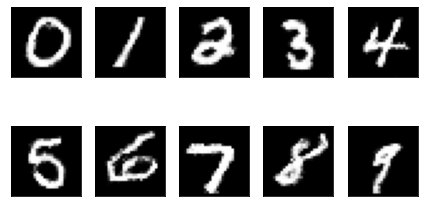

100%|██████████| 468/468 [00:27<00:00, 17.26it/s]


epoch = 117/150, d_loss=0.675, g_loss=0.798                                                                                                     


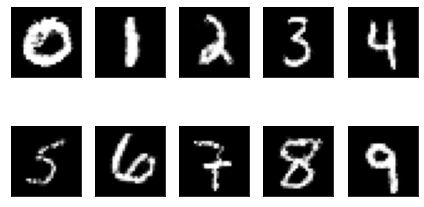

100%|██████████| 468/468 [00:27<00:00, 17.06it/s]


epoch = 118/150, d_loss=0.687, g_loss=0.839                                                                                                     


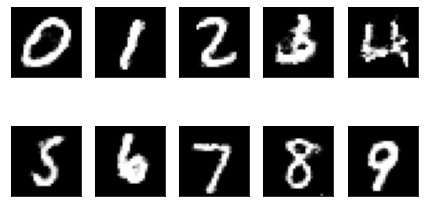

100%|██████████| 468/468 [00:27<00:00, 17.30it/s]


epoch = 119/150, d_loss=0.679, g_loss=0.837                                                                                                     


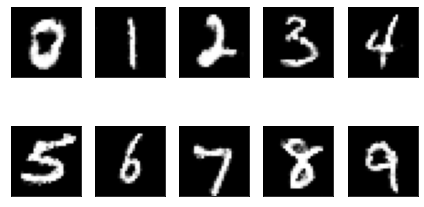

100%|██████████| 468/468 [00:28<00:00, 16.62it/s]


epoch = 120/150, d_loss=0.675, g_loss=0.821                                                                                                     


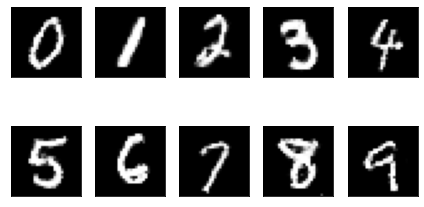

100%|██████████| 468/468 [00:26<00:00, 17.47it/s]


epoch = 121/150, d_loss=0.677, g_loss=0.816                                                                                                     


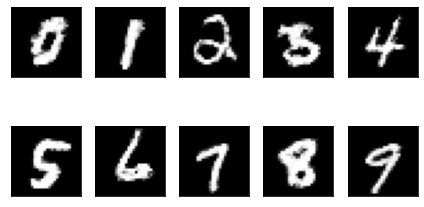

100%|██████████| 468/468 [00:27<00:00, 16.89it/s]


epoch = 122/150, d_loss=0.681, g_loss=0.802                                                                                                     


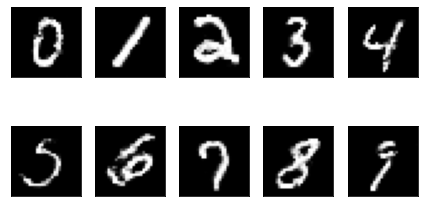

100%|██████████| 468/468 [00:27<00:00, 17.31it/s]


epoch = 123/150, d_loss=0.680, g_loss=0.818                                                                                                     


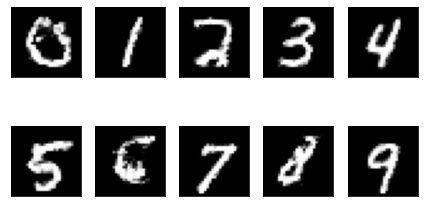

100%|██████████| 468/468 [00:27<00:00, 16.85it/s]


epoch = 124/150, d_loss=0.686, g_loss=0.817                                                                                                     


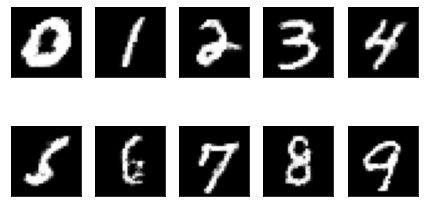

100%|██████████| 468/468 [00:27<00:00, 16.86it/s]


epoch = 125/150, d_loss=0.665, g_loss=0.835                                                                                                     


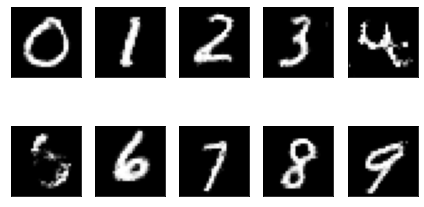

100%|██████████| 468/468 [00:27<00:00, 16.95it/s]


epoch = 126/150, d_loss=0.675, g_loss=0.815                                                                                                     


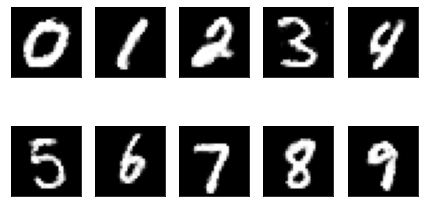

100%|██████████| 468/468 [00:26<00:00, 17.38it/s]


epoch = 127/150, d_loss=0.677, g_loss=0.827                                                                                                     


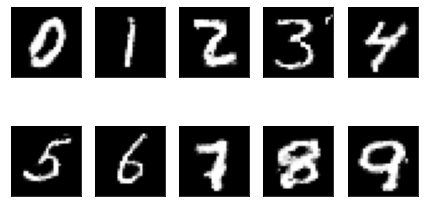

100%|██████████| 468/468 [00:27<00:00, 17.14it/s]


epoch = 128/150, d_loss=0.670, g_loss=0.823                                                                                                     


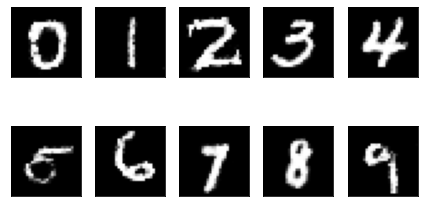

100%|██████████| 468/468 [00:26<00:00, 17.59it/s]


epoch = 129/150, d_loss=0.662, g_loss=0.842                                                                                                     


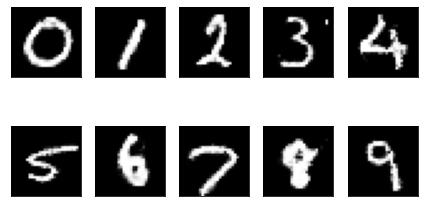

100%|██████████| 468/468 [00:27<00:00, 17.16it/s]


epoch = 130/150, d_loss=0.674, g_loss=0.797                                                                                                     


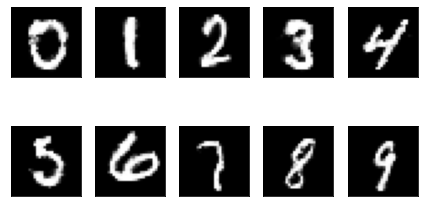

100%|██████████| 468/468 [00:27<00:00, 16.82it/s]


epoch = 131/150, d_loss=0.677, g_loss=0.811                                                                                                     


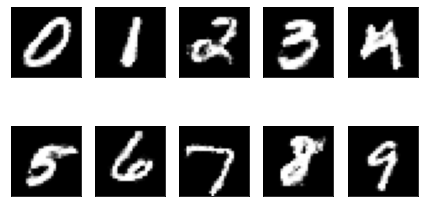

100%|██████████| 468/468 [00:27<00:00, 17.19it/s]


epoch = 132/150, d_loss=0.674, g_loss=0.832                                                                                                     


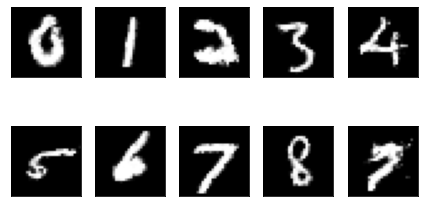

100%|██████████| 468/468 [00:27<00:00, 17.12it/s]


epoch = 133/150, d_loss=0.674, g_loss=0.805                                                                                                     


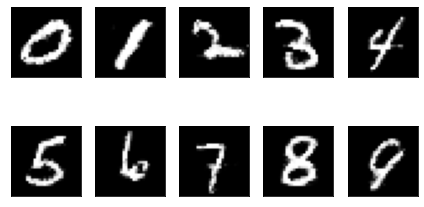

100%|██████████| 468/468 [00:26<00:00, 17.35it/s]


epoch = 134/150, d_loss=0.675, g_loss=0.854                                                                                                     


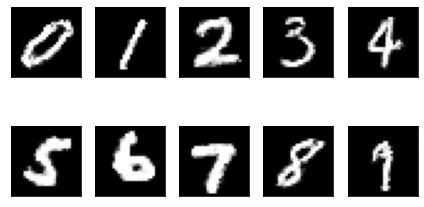

100%|██████████| 468/468 [00:27<00:00, 17.07it/s]


epoch = 135/150, d_loss=0.676, g_loss=0.835                                                                                                     


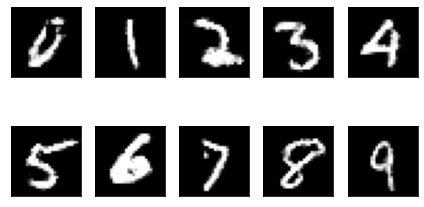

100%|██████████| 468/468 [00:27<00:00, 17.25it/s]


epoch = 136/150, d_loss=0.676, g_loss=0.834                                                                                                     


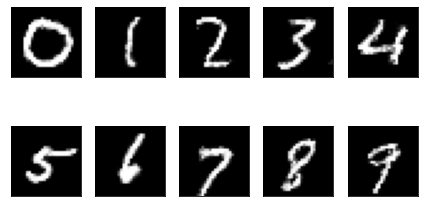

100%|██████████| 468/468 [00:27<00:00, 16.92it/s]


epoch = 137/150, d_loss=0.675, g_loss=0.790                                                                                                     


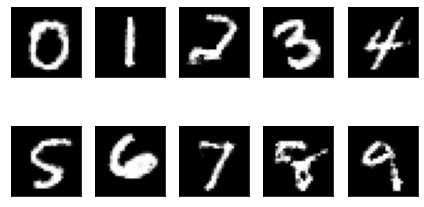

100%|██████████| 468/468 [00:27<00:00, 17.27it/s]


epoch = 138/150, d_loss=0.682, g_loss=0.804                                                                                                     


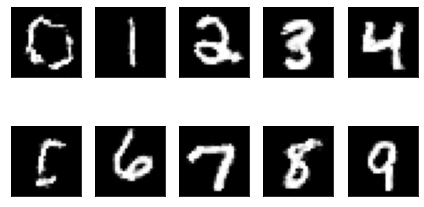

100%|██████████| 468/468 [00:27<00:00, 16.84it/s]


epoch = 139/150, d_loss=0.681, g_loss=0.824                                                                                                     


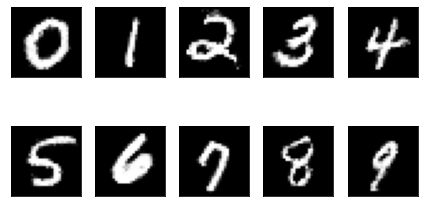

100%|██████████| 468/468 [00:27<00:00, 17.22it/s]


epoch = 140/150, d_loss=0.689, g_loss=0.794                                                                                                     


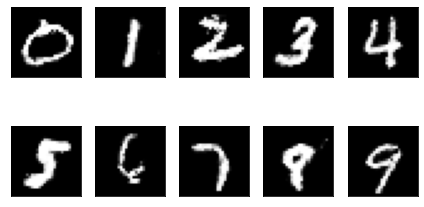

100%|██████████| 468/468 [00:27<00:00, 17.16it/s]


epoch = 141/150, d_loss=0.692, g_loss=0.827                                                                                                     


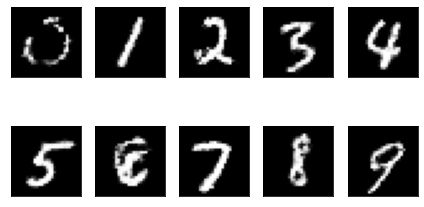

100%|██████████| 468/468 [00:27<00:00, 17.28it/s]


epoch = 142/150, d_loss=0.678, g_loss=0.812                                                                                                     


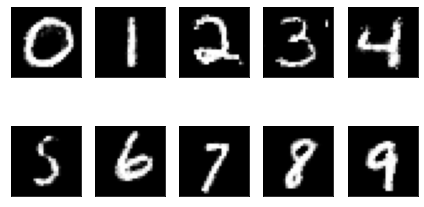

100%|██████████| 468/468 [00:28<00:00, 16.51it/s]


epoch = 143/150, d_loss=0.681, g_loss=0.798                                                                                                     


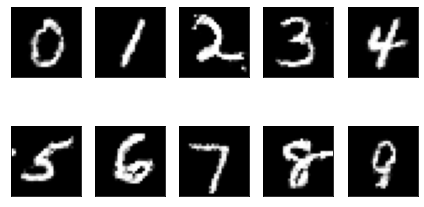

100%|██████████| 468/468 [00:27<00:00, 17.06it/s]


epoch = 144/150, d_loss=0.686, g_loss=0.799                                                                                                     


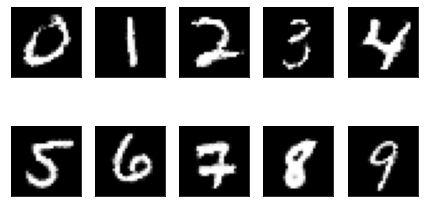

100%|██████████| 468/468 [00:27<00:00, 17.07it/s]


epoch = 145/150, d_loss=0.690, g_loss=0.829                                                                                                     


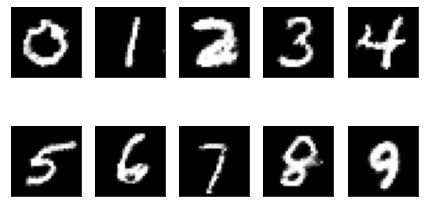

100%|██████████| 468/468 [00:27<00:00, 16.94it/s]


epoch = 146/150, d_loss=0.684, g_loss=0.778                                                                                                     


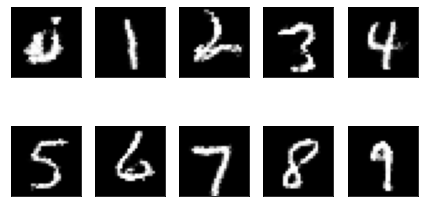

100%|██████████| 468/468 [00:27<00:00, 17.03it/s]


epoch = 147/150, d_loss=0.671, g_loss=0.815                                                                                                     


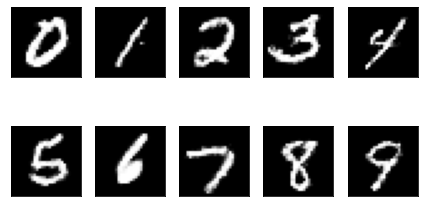

100%|██████████| 468/468 [00:27<00:00, 16.94it/s]


epoch = 148/150, d_loss=0.678, g_loss=0.823                                                                                                     


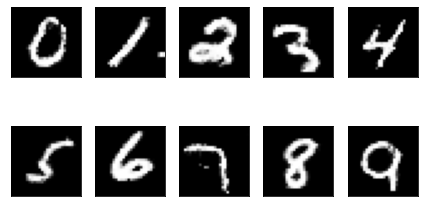

100%|██████████| 468/468 [00:27<00:00, 17.15it/s]


epoch = 149/150, d_loss=0.686, g_loss=0.821                                                                                                     


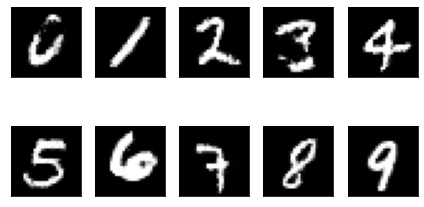

100%|██████████| 468/468 [00:27<00:00, 16.78it/s]


epoch = 150/150, d_loss=0.675, g_loss=0.798                                                                                                     


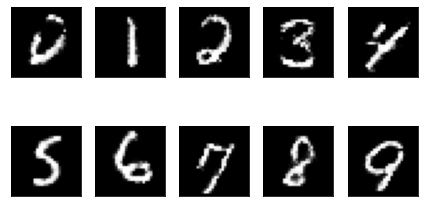

100%|██████████| 468/468 [00:27<00:00, 17.10it/s]


epoch = 151/150, d_loss=0.678, g_loss=0.797                                                                                                     


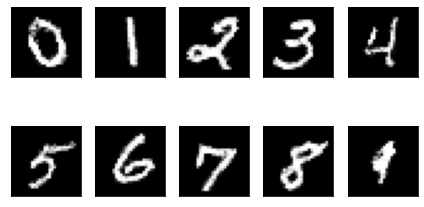

In [20]:
epochs = 150
batch_size = 128
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

# X_train =  X_train[:20000]
for e in range(epochs + 1):
    for i in tqdm(range(len(X_train) // batch_size)):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = gan.train_on_batch(x=[z, random_labels], y=real)
   
        """print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )"""
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 1 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, z_dim))
        labels = np.arange(0, 10).reshape(-1, 1)

        x_fake = generator.predict([z, labels])

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.savefig('./' + f'{e}_epoch.png')
        plt.show()

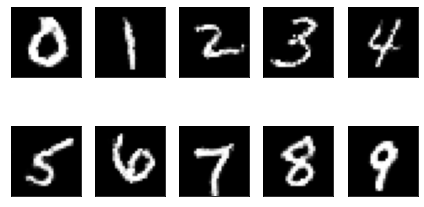

In [40]:
samples = 10

z = np.random.normal(loc=0, scale=1, size=(samples, z_dim))
labels = np.arange(0, 10).reshape(-1, 1)
x_fake = generator.predict([z, labels])

for k in range(samples):
    plt.subplot(2, 5, k+1)
    plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

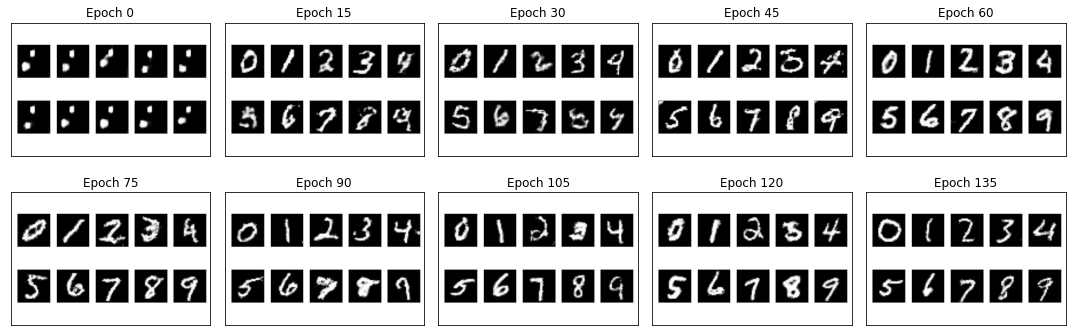

In [49]:
samples = 10

plt.figure(figsize=(15,5))
for k in range(samples):
    plt.subplot(2, 5, k+1)
    plt.imshow(plt.imread(f'./{k*15}_epoch.png'), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Epoch {k*15}')

plt.tight_layout()
plt.show()

# Create gif

In [51]:
import imageio
images = []
for epoch in range(epochs):
    images.append(imageio.imread(f'./{epoch}_epoch.png'))
imageio.mimsave('./DCGAN.gif', images)